In [3]:
from moku.instruments import PIDController
from moku.instruments import Oscilloscope
from numpy import sqrt, pi, array, arange, polyfit

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import datetime

%matplotlib

Using matplotlib backend: Qt5Agg


# Stability Measurements

In [ ]:
# ----- data ----- #
data = np.flip(np.loadtxt('08_09_2021_testrun.csv', delimiter=',', skiprows=1, usecols=[1,2,3]), axis=0)
time = np.flip(np.loadtxt('08_09_2021_testrun.csv', delimiter=',', skiprows=1, usecols=0, dtype='str'))
labels=['path', 'trash', 'spec']

props = dict(boxstyle='round', facecolor='wheat', alpha=1)
means = []; stds = []
fig, ax = plt.subplots(figsize=(15,5))

# ----- calculate ----- #
for i in range(len(data[0,:])):
    mean = np.round(np.mean(data[:,i]),3); std = np.round(np.std(data[:,i]),3);means.append(mean); stds.append(std)
    
    ax.text(11000,mean-1, labels[i] +': \n mean = ' + str(mean) + ' V \n std = ' + str(std),fontsize=14, bbox=props)
    ax.axhline(mean, label='mean_'+labels[i], c='k')

# ----- plot ----- #

ax.plot(time, data, label=labels)

ax.legend(); ax.set_xlabel('time'); ax.set_ylabel('voltage')
ax.set_xticks(np.arange(0, len(data), int(len(data)/10)))
ax.set_xticklabels(time[np.arange(0, len(data), int(len(data)/10))], rotation=90)
ax.set_title('Longer measurement test for path and after fiber', fontsize=20)

(array([], dtype=int64),)


Text(0.5, 1.0, '13/09/2021 - Stability test (laser lock, MOT path, trash, spectroscopy)')

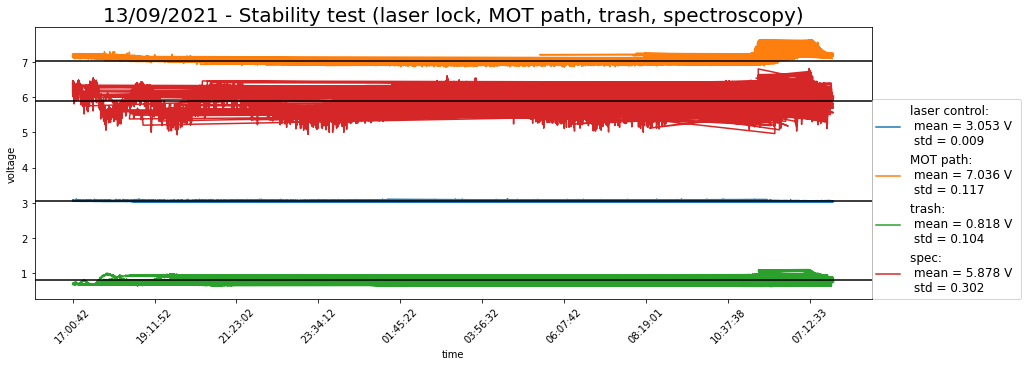

In [12]:
R1 = 47000.0; R2 = 33000.0;
# ----- data ----- #
data = np.flip(np.loadtxt('13_09_2021-08_19_20-testrun.csv', delimiter=',', skiprows=1, usecols=[3,4,5,6]), axis=0)
data[:,1:] = data[:,1:] * ((R1 + R2)/R2)
time = np.flip(np.loadtxt('13_09_2021-08_19_20-testrun.csv', delimiter=',', skiprows=1, usecols=0, dtype='str'))
labels=['laser control', 'MOT path', 'trash', 'spec']; col = list(mcolors.TABLEAU_COLORS)

props = dict(boxstyle='round', facecolor='wheat', alpha=1)
means = []; stds = []
fig, ax = plt.subplots(figsize=(15,5))

# ----- calculate ----- #
for i in range(len(data[0,:])):
    mean = np.round(np.mean(data[:,i]),3); std = np.round(np.std(data[:,i]),3);means.append(mean); stds.append(std)
    
    # ax.text(1,0.8-i*0.3, labels[i] +': \n mean = ' + str(mean) + ' V \n std = ' + str(std), fontsize=14, transform=ax.transAxes, bbox=props)
    ax.plot(time, data[:,i], label=labels[i]+': \n mean = ' + str(mean) + ' V \n std = ' + str(std), c=col[i])
    ax.axhline(mean, c='k')

# ----- plot ----- #

# ax.plot(time, data, label=labels, c=col)
print(np.where(time == '17:00:50'))

ax.legend(loc=(1,0), fontsize=12); ax.set_xlabel('time'); ax.set_ylabel('voltage')
ax.set_xticks(np.arange(0, len(data), int(len(data)/10)))
ax.set_xticklabels(time[np.arange(0, len(data), int(len(data)/10))], rotation=45)
ax.set_title('13/09/2021 - Stability test (laser lock, MOT path, trash, spectroscopy)', fontsize=20)

Text(0.5, 1.0, '10-13/09/2021 - Stability test (laser lock, MOT path, trash, spectroscopy)')

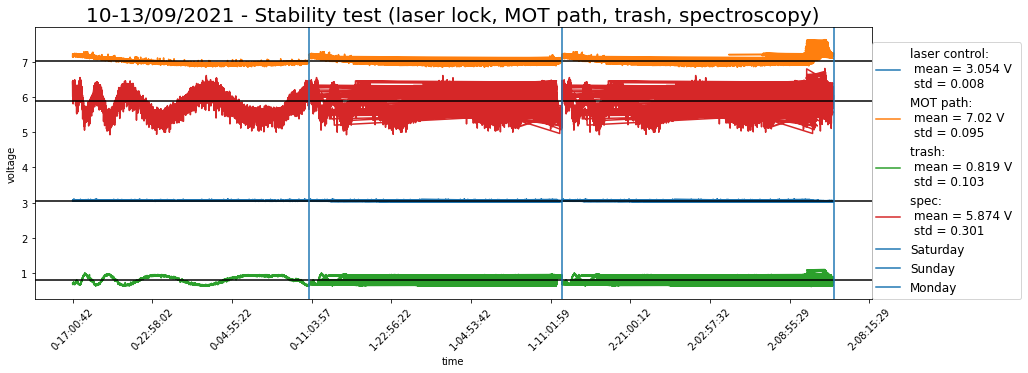

In [7]:
R1 = 47000.0; R2 = 33000.0;
# ----- data ----- #
data0 = np.flip(np.loadtxt('11_09_2021-11_06_06-testrun.csv', delimiter=',', skiprows=1, usecols=[3,4,5,6]), axis=0)
data1 = np.flip(np.loadtxt('12_09_2021-08_04_25-testrun.csv', delimiter=',', skiprows=1, usecols=[3,4,5,6]), axis=0)
data2 = np.flip(np.loadtxt('13_09_2021-08_19_20-testrun.csv', delimiter=',', skiprows=1, usecols=[3,4,5,6]), axis=0)
data = np.concatenate((data0, data1, data2), axis=0)

data[:,1:] = data[:,1:] * ((R1 + R2)/R2)

time0 = np.char.add('0-', np.flip(np.loadtxt('11_09_2021-11_06_06-testrun.csv', delimiter=',', skiprows=1, usecols=0, dtype='str')))
time1 = np.char.add('1-', np.flip(np.loadtxt('12_09_2021-08_04_25-testrun.csv', delimiter=',', skiprows=1, usecols=0, dtype='str')))
time2 = np.char.add('2-', np.flip(np.loadtxt('13_09_2021-08_19_20-testrun.csv', delimiter=',', skiprows=1, usecols=0, dtype='str')))
time = np.concatenate((time0, time1, time2))

labels=['laser control', 'MOT path', 'trash', 'spec']; col = list(mcolors.TABLEAU_COLORS)

props = dict(boxstyle='round', facecolor='wheat', alpha=1)
means = []; stds = []
fig, ax = plt.subplots(figsize=(15,5))

# ----- calculate ----- #
for i in range(len(data[0,:])):
    mean = np.round(np.mean(data[:,i]),3); std = np.round(np.std(data[:,i]),3);means.append(mean); stds.append(std)
    
    # ax.text(1,0.8-i*0.3, labels[i] +': \n mean = ' + str(mean) + ' V \n std = ' + str(std), fontsize=14, transform=ax.transAxes, bbox=props)
    ax.plot(time, data[:,i], label=labels[i]+': \n mean = ' + str(mean) + ' V \n std = ' + str(std), c=col[i])
    ax.axhline(mean, c='k')

# ----- plot ----- #

# ax.plot(time, data, label=labels, c=col)

ax.axvline(time0[-1], label='Saturday'), ax.axvline(time1[-1], label='Sunday'), ax.axvline(time2[-1], label='Monday')

ax.legend(loc=(1,0), fontsize=12); ax.set_xlabel('time'); ax.set_ylabel('voltage')
ax.set_xticks(np.arange(0, len(data), int(len(data)/10)))
ax.set_xticklabels(time[np.arange(0, len(data), int(len(data)/10))], rotation=45)
ax.set_title('10-13/09/2021 - Stability test (laser lock, MOT path, trash, spectroscopy)', fontsize=20)

Text(0.5, 1.0, '14/09/2021 - Stability test (laser lock, MOT path, trash, spectroscopy)')

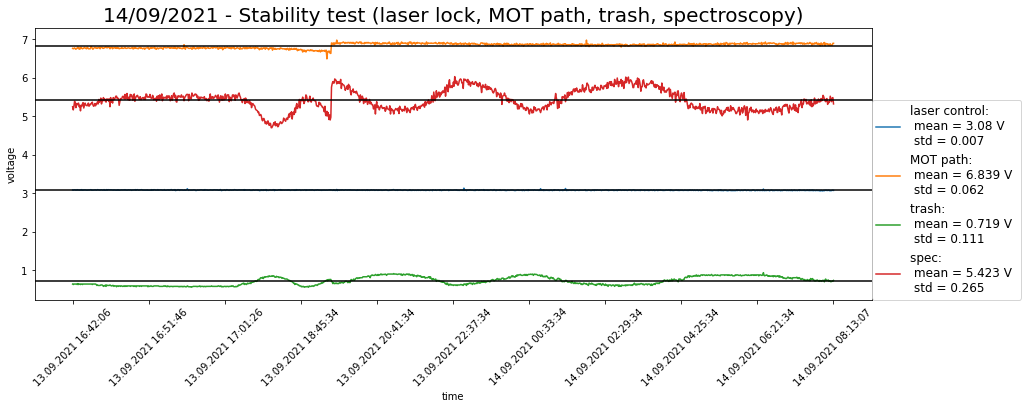

In [6]:
R1 = 47000.0; R2 = 33000.0;
# ----- data ----- #
data = np.flip(np.loadtxt('14_09_2021-08_13_12-testrun.csv', delimiter=',', skiprows=1, usecols=[1,2,3,4]), axis=0)
time = np.flip(np.loadtxt('14_09_2021-08_13_12-testrun.csv', delimiter=',', skiprows=1, usecols=0, dtype='str'))
labels=['laser control', 'MOT path', 'trash', 'spec']; col = list(mcolors.TABLEAU_COLORS)
data[:,1:] = data[:,1:] * ((R1 + R2)/R2)

fig, ax = plt.subplots(figsize=(15,5))

# ----- calculate ----- #
for i in range(len(data[0,:])):
    mean = np.round(np.mean(data[:,i]),3); std = np.round(np.std(data[:,i]),3)
    
    ax.plot(time, data[:,i], label=labels[i]+': \n mean = ' + str(mean) + ' V \n std = ' + str(std), c=col[i])
    ax.axhline(mean, c='k')

# ----- plot ----- #

ax.legend(loc=(1,0), fontsize=12); ax.set_xlabel('time'); ax.set_ylabel('voltage')
ax.set_xticks(np.arange(0, len(data), int(len(data)/10)))
ax.set_xticklabels(time[np.arange(0, len(data), int(len(data)/10))], rotation=45)
ax.set_title('14/09/2021 - Stability test (laser lock, MOT path, trash, spectroscopy)', fontsize=20)

# MOKU:GO

In [4]:
# This example demonstrates how you can configure the Oscilloscope instrument,
# and view triggered time-voltage data frames in real-time.
#
# (c) 2021 Liquid Instruments Pty. Ltd.

print('START : ' + datetime.datetime.now().strftime("%d/%m/%Y, %H:%M:%S"))

# Connect to your Moku by its ip address using Oscilloscope('192.168.###.###')
# or by its serial number using Oscilloscope(serial=123)
i = Oscilloscope('129.206.180.142', force_connect=True)

try:
    # Trigger on input Channel 1, rising edge, 0V 
    i.set_trigger(type='Edge', source='Input1', level=0)

    # View +-5usec, i.e. trigger in the centre
    i.set_timebase(-5e-6, 5e-6)

    # Generate an output sine wave on Channel 1, 1Vpp, 1MHz, 0V offset
    i.generate_waveform(1, 'DC', amplitude=1)
    i.generate_waveform(2, 'Sine', amplitude=1, frequency=1e6)

    # Set the data source of Channel 1 to be Input 1
    i.set_source(1, 'Input1')

    # Set the data source of Channel 2 to the generated output sinewave
    i.set_source(2, 'Input2')


    # Get initial data frame to set up plotting parameters. This can be done
    # once if we know that the axes aren't going to change (otherwise we'd do
    # this in the loop)
    data = i.get_data()

    # Set up the plotting parameters
    plt.ion()
    plt.show()
    plt.grid(b=True)
    plt.ylim([-1, 1])
    plt.xlim([data['time'][0], data['time'][-1]])

    line1, = plt.plot([], label='channel 1')
    line2, = plt.plot([], label='channel 2')

    # Configure labels for axes
    ax = plt.gca()

    # This loops continuously updates the plot with new data
    while True:
        # Get new data
        data = i.get_data()

        # Update the plot
        line1.set_ydata(data['ch1'])
        line2.set_ydata(data['ch2'])
        line1.set_xdata(data['time'])
        line2.set_xdata(data['time'])
        
        ax.set_title(datetime.datetime.now().strftime("%d/%m/%Y, %H:%M:%S"))
        ax.legend()

        plt.pause(0.001)
        
except Exception as e:
    print(f'Exception occurred: {e}')
finally:
    # Close the connection to the Moku device
    # This ensures network resources and released correctly
    i.relinquish_ownership()

START : 17/09/2021, 10:47:56


KeyboardInterrupt: 

In [5]:
i.relinquish_ownership()